<a href="https://colab.research.google.com/github/tjwei/GAN_Tutorial/blob/master/DCGAN_intro_for_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# for tf 2.0
!pip install -U tensorflow-gpu

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display
tf.__version__

'2.0.0'

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [4]:
train_images.dtype, train_images.shape

(dtype('uint8'), (50000, 32, 32, 3))

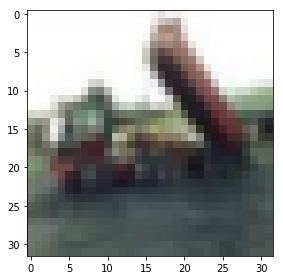

In [5]:
imshow(train_images[2])

In [0]:
def img_to_float(img):
  return (np.float32(img)-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)

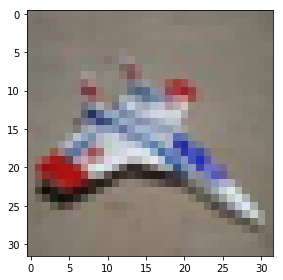

In [7]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[30]))

In [0]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_img_f32).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Conv2D
latent_dim = 64
generator = tf.keras.Sequential([
    Dense(4*4*256, use_bias=False, input_shape=(latent_dim,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((4, 4, 256)),
    Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')
]
)

In [0]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
discriminator =  tf.keras.Sequential([
   Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(32,32, 3)),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Conv2D(128, (3, 3), strides=(2, 2), padding='same',use_bias=False),
   BatchNormalization(),
   LeakyReLU(),
   Flatten(),
   Dense(1)]
)

In [0]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(generated_output):
    return loss_fn(tf.ones_like(generated_output), generated_output)

In [0]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_loss = loss_fn(tf.ones_like(real_output), real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = loss_fn(tf.zeros_like(generated_output), generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
EPOCHS = 50
num_examples_to_generate = 16

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 latent_dim])

In [0]:
@tf.function
def train_step(images):
   # generating noise from a normal distribution
      noise = tf.random.normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
      
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      return gen_loss, disc_loss

0 [3.9751048  0.13134721] 44.13475203514099


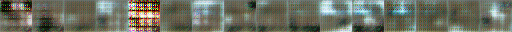

1 [3.2868326  0.28866765] 40.48990249633789


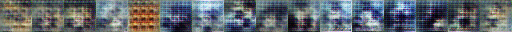

2 [3.076736   0.30161512] 38.93795561790466


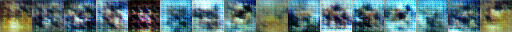

3 [3.0956535  0.31432098] 38.96622967720032


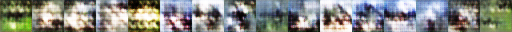

4 [3.0143592  0.34910005] 37.900643825531006


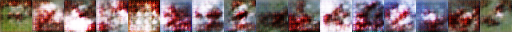

5 [2.9795942  0.37872306] 37.94449853897095


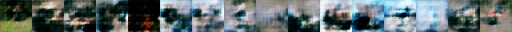

6 [2.904942   0.38057727] 37.80193829536438


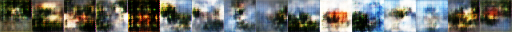

7 [3.0542655  0.37108332] 38.084901094436646


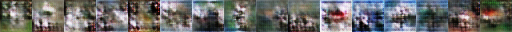

8 [3.0442138  0.35136998] 37.96368074417114


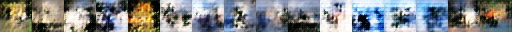

9 [3.3811104 0.303347 ] 38.10476303100586


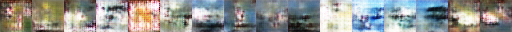

10 [3.5624564  0.27234462] 37.986165285110474


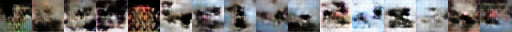

11 [3.7899172  0.22931482] 37.9831976890564


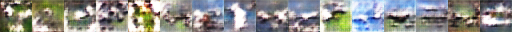

12 [4.020749   0.23603597] 39.07213544845581


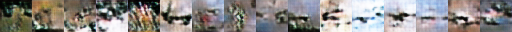

13 [3.8314173  0.24740651] 39.309913873672485


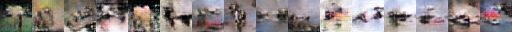

14 [3.546728  0.3097074] 39.11774730682373


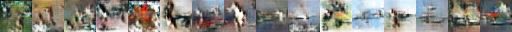

15 [3.2418187  0.36314684] 39.11569809913635


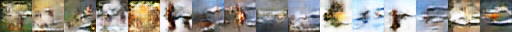

16 [2.956416  0.3855641] 39.12081241607666


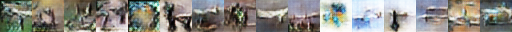

17 [2.7944639  0.44248843] 39.22831058502197


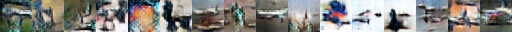

18 [2.7444668  0.44368163] 39.19598889350891


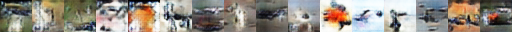

19 [2.6195593  0.48398894] 39.185022830963135


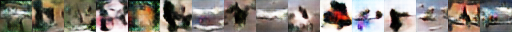

20 [2.519063  0.5313307] 39.189756631851196


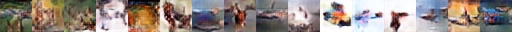

21 [2.342285  0.5428328] 39.343955516815186


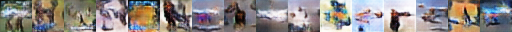

22 [2.3022714  0.57173765] 39.09636354446411


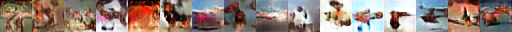

23 [2.177472 0.579076] 39.20559811592102


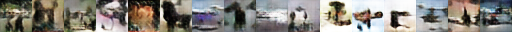

24 [2.0714014 0.6585678] 39.13117289543152


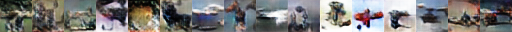

25 [2.0559397 0.6241208] 39.177268505096436


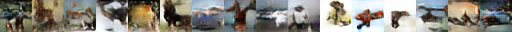

26 [2.0865035 0.6107526] 39.071396827697754


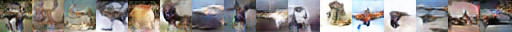

27 [2.118239   0.59347975] 39.14820337295532


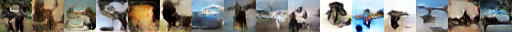

28 [2.1002338  0.62578255] 39.13651919364929


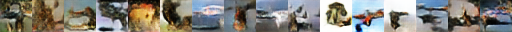

29 [2.1158884  0.56102073] 39.2570104598999


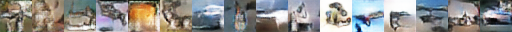

In [16]:
for epoch in range(30):
  start_time = time.time()
  loss = []
  for images in train_dataset:
      loss.append(np.array(train_step(images)))
  fake = generator(random_vector_for_generation, training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2,3]).reshape((32,-1,3))
  print(epoch, np.mean(loss, axis=0), time.time()-start_time)
  display(PIL.Image.fromarray(fake_concat))
  
  